In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from statistics import mean, median
import scipy.stats as sts
from scipy.signal import argrelextrema
from scipy.fft import fft, fftfreq, ifft
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import warnings
from pandas.core.common import SettingWithCopyWarning
from os.path import exists

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [6]:
for i in range(1, 106):
    try:
        codx = pd.read_csv('cod-torsions/t{}-rings.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'count-xtal'})
        codx['deg'] = codx.index.astype('int32')
        for angle in codx['deg']:
            if int(angle) > 180:
                codx['count-xtal'].loc[codx['deg'] == abs(int(angle) - 360)] += float(codx['count-xtal'].loc[codx['deg'] == int(angle)])
        codc = pd.read_csv('cod-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'count-conf'})
        codc['deg'] = codc.index.astype('int32')
        for angle in codc['deg']:
            if int(angle) > 180:
                codc['count-conf'].loc[codc['deg'] == abs(int(angle) - 360)] += float(codc['count-conf'].loc[codc['deg'] == int(angle)])
        codx = codx[0:181]
        codc = codc[0:181]
        cod = pd.merge(codx, codc, on='deg')
        cod['% in bin xtal'] = cod['count-xtal'] / cod['count-xtal'].sum() * 100
        cod['% in bin conf'] = cod['count-conf'] / cod['count-conf'].sum() * 100

        pqr = pd.read_csv('pqr-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'pqr-count'})
        pqr['deg'] = pqr.index.astype('int32')
        pub = pd.read_csv('pubchemqc-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'pub-count'})
        pub['deg'] = pub.index.astype('int32')
        zinc = pd.read_csv('zinc-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'zinc-count'})
        zinc['deg'] = zinc.index.astype('int32')

        gfn = pd.merge(pqr, pub, on='deg')
        gfn = pd.merge(gfn, zinc, on='deg')
        gfn['total-count'] = gfn['pqr-count'] + gfn['pub-count'] + gfn['zinc-count']

        for angle in gfn['deg']:
            if int(angle) > 180:
                gfn['total-count'].loc[gfn['deg'] == abs(int(angle) - 360)] += float(gfn['total-count'].loc[gfn['deg'] == int(angle)])
        gfn = gfn[0:181]
        gfn['% in bin gfn2'] = gfn['total-count'] / gfn['total-count'].sum() * 100

        df = pd.merge(cod, gfn, on='deg')

        fig = plt.figure(dpi=200, figsize=(8, 6))
        grid = fig.add_gridspec(8, 6)
        ax1 = fig.add_subplot(grid[0:2, 0:2])
        ax2 = fig.add_subplot(grid[0:2, 2:4], sharey=ax1)
        ax3 = fig.add_subplot(grid[0:2, 4:6], sharey=ax1)
        ax4 = fig.add_subplot(grid[2:4, 0:2])
        ax5 = fig.add_subplot(grid[2:4, 2:4], sharey=ax4)
        ax6 = fig.add_subplot(grid[2:4, 4:6], sharey=ax4)
        ax7 = fig.add_subplot(grid[4:8:, 1:5])


        plt.suptitle('Torsion Ring Pattern {}'.format(i), fontsize=16, x=.54)
        bin5 = np.arange(0, 181, 5)
        conf5 = np.add.reduceat(np.asarray(df['% in bin xtal']), np.arange(0, len(np.asarray(df['% in bin xtal'])), 5))
        ax1.hist(x=bin5 , bins=bin5, weights=conf5)
        ax1.set_ylabel('% in Bin')
        ax1.set_xlabel('Torsion Angle ($^\circ$)')
        ax1.set_xlim(0,180)
        ax1.set_xticks(np.arange(0,181, 60))
        ax1.set_title('COD Experimental Torsions')

        bin5 = np.arange(0, 181, 5)
        conf5 = np.add.reduceat(np.asarray(df['% in bin conf']), np.arange(0, len(np.asarray(df['% in bin conf'])), 5))
        ax2.hist(x=bin5 , bins=bin5, weights=conf5)
        ax2.set_ylabel('% in Bin')
        ax2.set_xlabel('Torsion Angle ($^\circ$)')
        ax2.set_xlim(0,180)
        ax2.set_xticks(np.arange(0,181, 60))
        ax2.set_title('COD Conformer Torsions')

        bin5 = np.arange(0, 181, 5)
        conf5 = np.add.reduceat(np.asarray(df['% in bin gfn2']), np.arange(0, len(np.asarray(df['% in bin gfn2'])), 5))
        ax3.hist(x=bin5 , bins=bin5, weights=conf5)
        ax3.set_ylabel('% in Bin')
        ax3.set_xlabel('Torsion Angle ($^\circ$)')
        ax3.set_xlim(0,180)
        ax3.set_xticks(np.arange(0,181, 60))
        ax3.set_title('GFN2 Torsions')

        ######################################################################
        sns.kdeplot(x=df['deg'], weights=df['% in bin xtal'], bw_adjust=0.2, cut=0, ax=ax4)
        ax4.set(xlabel=None)
        ax4.set(ylabel=None)
        ax4.set_xlabel('Torsion Angle ($^\circ$)')
        ax4.set_ylabel('% in Bin')
        ax4.set_xlim(0,180)
        ax4.set_xticks(np.arange(0,181, 60))
        if ax4.lines:
            kdecurve = ax4.lines[0]
            lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
            # get list of min and max plus 0 and 359
            minmax = list(lmax) # avoid min for now as too crowded plotting wise
            minmax = sorted(minmax)
            # get the values at the min and maxes
            degv = [kdecurve.get_ydata()[lm] for lm in minmax]
            degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
            for k in range(len(degv)):
                ax4.annotate(degs[k], xy=(degs[k], degv[k]),
                               fontsize=6, xytext=(degs[k], degv[k]))
            ax4.plot(degs, degv, '.', c='k')

        sns.kdeplot(x=df['deg'], weights=df['% in bin conf'], bw_adjust=0.2, cut=0, ax=ax5)
        ax5.set(xlabel=None)
        ax5.set(ylabel=None)
        ax5.set_xlabel('Torsion Angle ($^\circ$)')
        ax5.set_ylabel('% in Bin')
        ax5.set_xlim(0,180)
        ax5.set_xticks(np.arange(0,181, 60))
        if ax5.lines:
            kdecurve = ax5.lines[0]
            lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
            # get list of min and max plus 0 and 359
            minmax = list(lmax) # avoid min for now as too crowded plotting wise
            minmax = sorted(minmax)
            # get the values at the min and maxes
            degv = [kdecurve.get_ydata()[lm] for lm in minmax]
            degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
            for k in range(len(degv)):
                ax5.annotate(degs[k], xy=(degs[k], degv[k]),
                               fontsize=6, xytext=(degs[k], degv[k]))
            ax5.plot(degs, degv, '.', c='k')

        sns.kdeplot(x=df['deg'], weights=df['% in bin gfn2'], bw_adjust=0.2, cut=0, ax=ax6)
        ax6.set(xlabel=None)
        ax6.set(ylabel=None)
        ax6.set_xlabel('Torsion Angle ($^\circ$)')
        ax6.set_ylabel('% in Bin')
        ax6.set_xlim(0,180)
        ax6.set_xticks(np.arange(0,181, 60))
        if ax6.lines:
            kdecurve = ax6.lines[0]
            lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
            # get list of min and max plus 0 and 359
            minmax = list(lmax) # avoid min for now as too crowded plotting wise
            minmax = sorted(minmax)
            # get the values at the min and maxes
            degv = [kdecurve.get_ydata()[lm] for lm in minmax]
            degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
            for k in range(len(degv)):
                ax6.annotate(degs[k], xy=(degs[k], degv[k]),
                               fontsize=6, xytext=(degs[k], degv[k]))
            ax6.plot(degs, degv, '.', c='k')
        ######################################################################
        if exists('smarts-figures/t{}-rings-smarts.png'.format(i)):
            img = mpimg.imread('smarts-figures/t{}-rings-smarts.png'.format(i))
            ax7.imshow(img)
        else:
            pass
        ax7.set_axis_off()

        plt.tight_layout()
    #     plt.show()
        plt.savefig('ring-figures/t{}-rings.pdf'.format(i))
        plt.close()
#         plt.show()
#         plt.savefig('ring-figures/t{}-rings.pdf'.format(i))
#         break
    except:
        print('Issue w/ Pattern {}'.format(i))

/home/dakota/anaconda3/envs/noncov/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dakota/anaconda3/envs/noncov/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dakota/anaconda3/envs/noncov/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


/home/dakota/anaconda3/envs/noncov/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/dakota/anaconda3/envs/noncov/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


[]


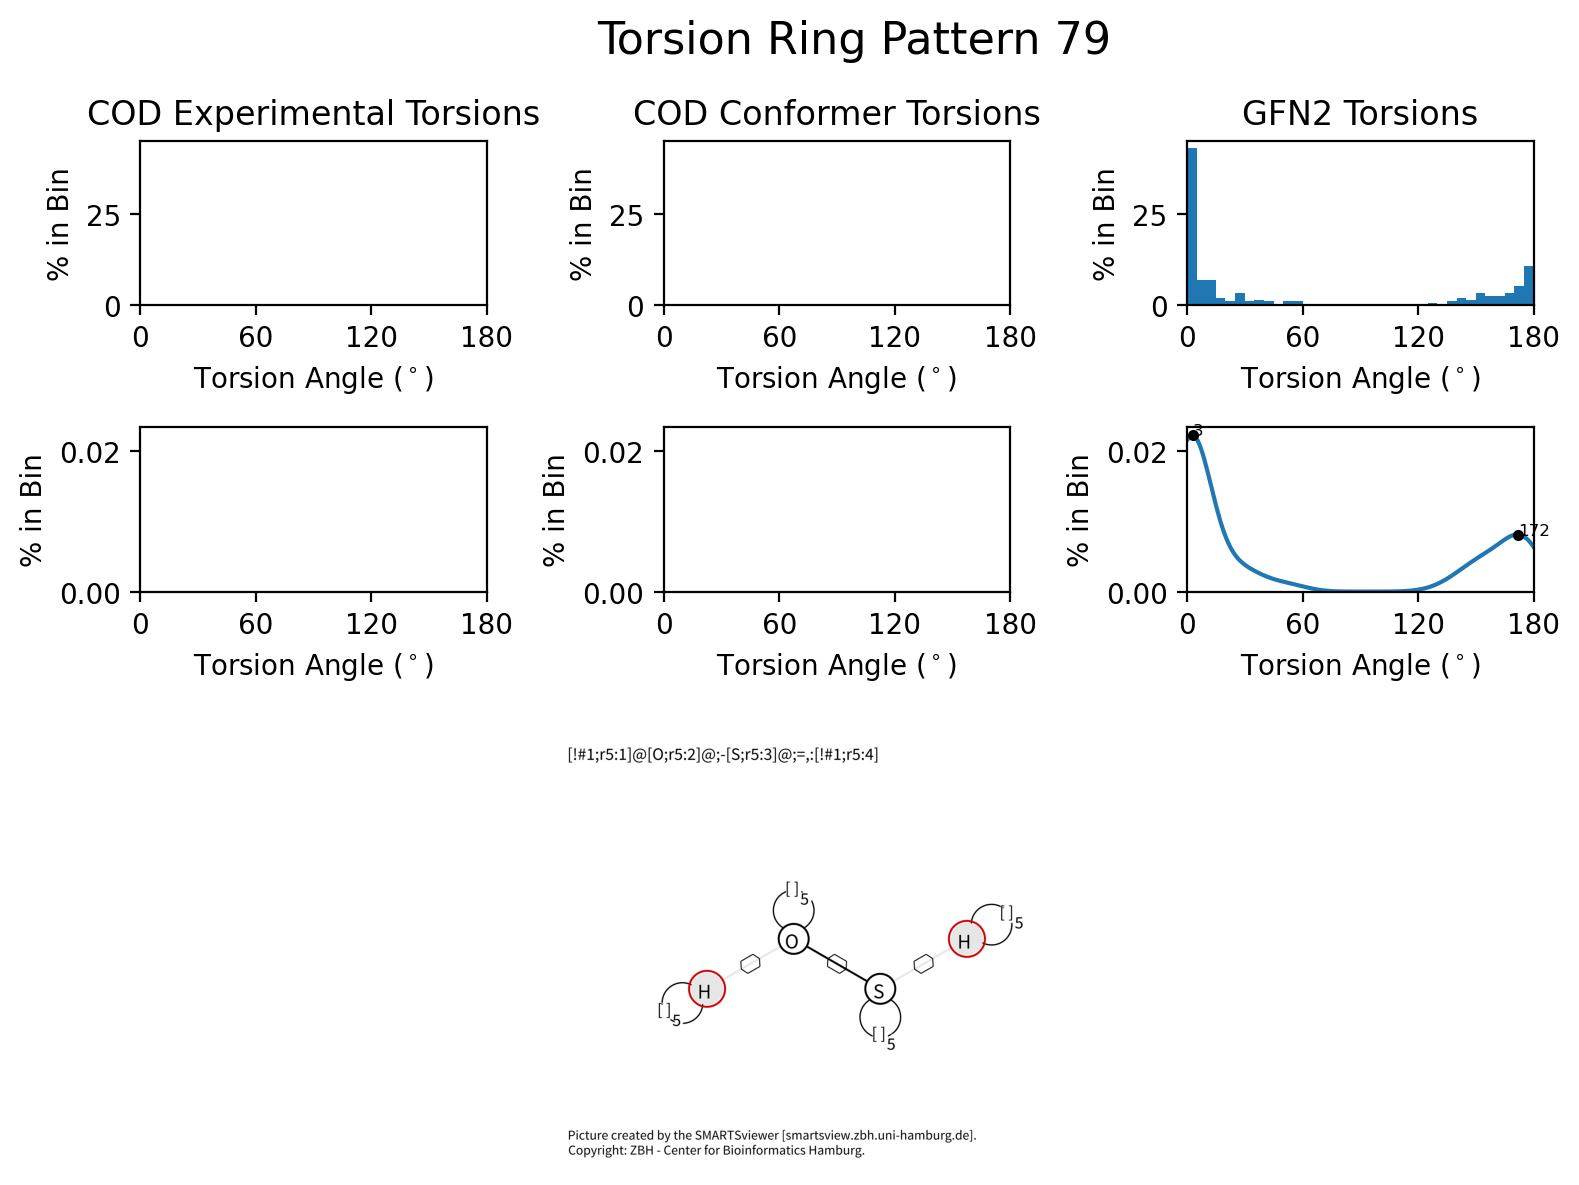

In [19]:
for i in range(79, 80):
#     try:
    codx = pd.read_csv('cod-torsions/t{}-rings.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'count-xtal'})
    codx['deg'] = codx.index.astype('int32')
    for angle in codx['deg']:
        if int(angle) > 180:
            codx['count-xtal'].loc[codx['deg'] == abs(int(angle) - 360)] += float(codx['count-xtal'].loc[codx['deg'] == int(angle)])
    codc = pd.read_csv('cod-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'count-conf'})
    codc['deg'] = codc.index.astype('int32')
    for angle in codc['deg']:
        if int(angle) > 180:
            codc['count-conf'].loc[codc['deg'] == abs(int(angle) - 360)] += float(codc['count-conf'].loc[codc['deg'] == int(angle)])
    codx = codx[0:181]
    codc = codc[0:181]
    cod = pd.merge(codx, codc, on='deg')
    cod['% in bin xtal'] = cod['count-xtal'] / cod['count-xtal'].sum() * 100
    cod['% in bin conf'] = cod['count-conf'] / cod['count-conf'].sum() * 100

    pqr = pd.read_csv('pqr-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'pqr-count'})
    pqr['deg'] = pqr.index.astype('int32')
    pub = pd.read_csv('pubchemqc-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'pub-count'})
    pub['deg'] = pub.index.astype('int32')
    zinc = pd.read_csv('zinc-torsions/t{}-rings-conf.txt'.format(i), delimiter=',', header=None).rename(columns={0: 'zinc-count'})
    zinc['deg'] = zinc.index.astype('int32')

    gfn = pd.merge(pqr, pub, on='deg')
    gfn = pd.merge(gfn, zinc, on='deg')
    gfn['total-count'] = gfn['pqr-count'] + gfn['pub-count'] + gfn['zinc-count']

    for angle in gfn['deg']:
        if int(angle) > 180:
            gfn['total-count'].loc[gfn['deg'] == abs(int(angle) - 360)] += float(gfn['total-count'].loc[gfn['deg'] == int(angle)])
    gfn = gfn[0:181]
    gfn['% in bin gfn2'] = gfn['total-count'] / gfn['total-count'].sum() * 100

    df = pd.merge(cod, gfn, on='deg')

    fig = plt.figure(dpi=200, figsize=(8, 6))
    grid = fig.add_gridspec(8, 6)
    ax1 = fig.add_subplot(grid[0:2, 0:2])
    ax2 = fig.add_subplot(grid[0:2, 2:4], sharey=ax1)
    ax3 = fig.add_subplot(grid[0:2, 4:6], sharey=ax1)
    ax4 = fig.add_subplot(grid[2:4, 0:2])
    ax5 = fig.add_subplot(grid[2:4, 2:4], sharey=ax4)
    ax6 = fig.add_subplot(grid[2:4, 4:6], sharey=ax4)
    ax7 = fig.add_subplot(grid[4:8:, 1:5])


    plt.suptitle('Torsion Ring Pattern {}'.format(i), fontsize=16, x=.54)
    bin5 = np.arange(0, 181, 5)
    conf5 = np.add.reduceat(np.asarray(df['% in bin xtal']), np.arange(0, len(np.asarray(df['% in bin xtal'])), 5))
    ax1.hist(x=bin5 , bins=bin5, weights=conf5)
    ax1.set_ylabel('% in Bin')
    ax1.set_xlabel('Torsion Angle ($^\circ$)')
    ax1.set_xlim(0,180)
    ax1.set_xticks(np.arange(0,181, 60))
    ax1.set_title('COD Experimental Torsions')

    bin5 = np.arange(0, 181, 5)
    conf5 = np.add.reduceat(np.asarray(df['% in bin conf']), np.arange(0, len(np.asarray(df['% in bin conf'])), 5))
    ax2.hist(x=bin5 , bins=bin5, weights=conf5)
    ax2.set_ylabel('% in Bin')
    ax2.set_xlabel('Torsion Angle ($^\circ$)')
    ax2.set_xlim(0,180)
    ax2.set_xticks(np.arange(0,181, 60))
    ax2.set_title('COD Conformer Torsions')

    bin5 = np.arange(0, 181, 5)
    conf5 = np.add.reduceat(np.asarray(df['% in bin gfn2']), np.arange(0, len(np.asarray(df['% in bin gfn2'])), 5))
    ax3.hist(x=bin5 , bins=bin5, weights=conf5)
    ax3.set_ylabel('% in Bin')
    ax3.set_xlabel('Torsion Angle ($^\circ$)')
    ax3.set_xlim(0,180)
    ax3.set_xticks(np.arange(0,181, 60))
    ax3.set_title('GFN2 Torsions')

    ######################################################################
    sns.kdeplot(x=df['deg'], weights=df['% in bin xtal'], bw_adjust=0.2, cut=0, ax=ax4)
    ax4.set(xlabel=None)
    ax4.set(ylabel=None)
    ax4.set_xlabel('Torsion Angle ($^\circ$)')
    ax4.set_ylabel('% in Bin')
    ax4.set_xlim(0,180)
    ax4.set_xticks(np.arange(0,181, 60))
    print(ax4.lines)
    if ax4.lines:
        kdecurve = ax4.lines[0]
        lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
        # get list of min and max plus 0 and 359
        minmax = list(lmax) # avoid min for now as too crowded plotting wise
        minmax = sorted(minmax)
        # get the values at the min and maxes
        degv = [kdecurve.get_ydata()[lm] for lm in minmax]
        degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
        for k in range(len(degv)):
            ax4.annotate(degs[k], xy=(degs[k], degv[k]),
                           fontsize=6, xytext=(degs[k], degv[k]))
        ax4.plot(degs, degv, '.', c='k')

    sns.kdeplot(x=df['deg'], weights=df['% in bin conf'], bw_adjust=0.2, cut=0, ax=ax5)
    ax5.set(xlabel=None)
    ax5.set(ylabel=None)
    ax5.set_xlabel('Torsion Angle ($^\circ$)')
    ax5.set_ylabel('% in Bin')
    ax5.set_xlim(0,180)
    ax5.set_xticks(np.arange(0,181, 60))
    if ax5.lines:
        kdecurve = ax5.lines[0]
        lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
        # get list of min and max plus 0 and 359
        minmax = list(lmax) # avoid min for now as too crowded plotting wise
        minmax = sorted(minmax)
        # get the values at the min and maxes
        degv = [kdecurve.get_ydata()[lm] for lm in minmax]
        degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
        for k in range(len(degv)):
            ax5.annotate(degs[k], xy=(degs[k], degv[k]),
                           fontsize=6, xytext=(degs[k], degv[k]))
        ax5.plot(degs, degv, '.', c='k')

    sns.kdeplot(x=df['deg'], weights=df['% in bin gfn2'], bw_adjust=0.2, cut=0, ax=ax6)
    ax6.set(xlabel=None)
    ax6.set(ylabel=None)
    ax6.set_xlabel('Torsion Angle ($^\circ$)')
    ax6.set_ylabel('% in Bin')
    ax6.set_xlim(0,180)
    ax6.set_xticks(np.arange(0,181, 60))
    kdecurve = ax6.lines[0]
    lmax = argrelextrema(kdecurve.get_ydata(), np.greater)[0] # local maxima
    # get list of min and max plus 0 and 359
    minmax = list(lmax) # avoid min for now as too crowded plotting wise
    minmax = sorted(minmax)
    # get the values at the min and maxes
    degv = [kdecurve.get_ydata()[lm] for lm in minmax]
    degs = [int(round(kdecurve.get_xdata()[lm])) for lm in minmax]
    for k in range(len(degv)):
        ax6.annotate(degs[k], xy=(degs[k], degv[k]),
                       fontsize=6, xytext=(degs[k], degv[k]))
    ax6.plot(degs, degv, '.', c='k')
    ######################################################################
    img = mpimg.imread('smarts-figures/t{}-rings-smarts.png'.format(i))
    ax7.imshow(img)
    ax7.set_axis_off()

    plt.tight_layout()
    plt.show()
#         plt.savefig('ring-figures/t{}-rings.pdf'.format(i))
    plt.close()
#         plt.show()
#         plt.savefig('ring-figures/t{}-rings.pdf'.format(i))
#         break
#     except:
#         print('Issue w/ Pattern {}'.format(i))